In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [3]:
df = pd.read_csv('DATOSSEGUNDOSOJA.csv',  parse_dates=[0], header=None,index_col=0, names=['fecha','cierre'])
df.head()

,cierre
fecha,
2004-05-01,221.0
2004-06-01,221.0
2004-07-01,219.0
2004-08-01,220.0
2004-09-01,220.0


In [4]:
df['weekday']=[x.weekday() for x in df.index]
df['month']=[x.month for x in df.index]
df.head()

,cierre,weekday,month
fecha,,,
2004-05-01,221.0,5,5
2004-06-01,221.0,1,6
2004-07-01,219.0,3,7
2004-08-01,220.0,6,8
2004-09-01,220.0,2,9


In [5]:
df.describe()

,cierre,weekday,month
count,3860.000000,3860.000000,3860.000000
mean,260.000596,2.397409,6.468394
std,60.532726,1.718637,3.419194
min,146.000000,0.000000,1.000000
25%,220.875000,1.000000,4.000000
50%,257.750000,2.000000,6.000000
75%,301.000000,4.000000,9.000000
max,442.000000,6.000000,12.000000


In [6]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [28]:
PASOS=7

# load dataset
values = df['cierre'].values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)

df['scaled'] = scaled
scaledMerge=df.drop('cierre',axis=1)
#print(scaledMerge.values)

# frame as supervised learning
reframed = series_to_supervised(scaledMerge, PASOS, 1)
reframed.head()

,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
fecha,,,,,,,,,,,,,,,,,,,,,
2004-01-14,5.0,5.0,-0.493243,1.0,6.0,-0.493243,3.0,7.0,-0.506757,6.0,...,-0.500000,2.0,12.0,-0.466216,1.0,1.0,-0.445946,2,1,-0.445946
2004-01-15,1.0,6.0,-0.493243,3.0,7.0,-0.506757,6.0,8.0,-0.500000,2.0,...,-0.466216,1.0,1.0,-0.445946,2.0,1.0,-0.445946,3,1,-0.452703
2004-01-16,3.0,7.0,-0.506757,6.0,8.0,-0.500000,2.0,9.0,-0.500000,2.0,...,-0.445946,2.0,1.0,-0.445946,3.0,1.0,-0.452703,4,1,-0.459459
2004-01-19,6.0,8.0,-0.500000,2.0,9.0,-0.500000,2.0,12.0,-0.466216,1.0,...,-0.445946,3.0,1.0,-0.452703,4.0,1.0,-0.459459,0,1,-0.432432
2004-01-20,2.0,9.0,-0.500000,2.0,12.0,-0.466216,1.0,1.0,-0.445946,2.0,...,-0.452703,4.0,1.0,-0.459459,0.0,1.0,-0.432432,1,1,-0.412162


In [29]:
newReframed=reframed.drop(['var1(t)','var2(t)'],axis=1)
print(newReframed.shape)
newReframed.head()

(3853, 22)


,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var3(t)
fecha,,,,,,,,,,,,,,,,,,,,,
2004-01-14,5.0,5.0,-0.493243,1.0,6.0,-0.493243,3.0,7.0,-0.506757,6.0,...,2.0,9.0,-0.500000,2.0,12.0,-0.466216,1.0,1.0,-0.445946,-0.445946
2004-01-15,1.0,6.0,-0.493243,3.0,7.0,-0.506757,6.0,8.0,-0.500000,2.0,...,2.0,12.0,-0.466216,1.0,1.0,-0.445946,2.0,1.0,-0.445946,-0.452703
2004-01-16,3.0,7.0,-0.506757,6.0,8.0,-0.500000,2.0,9.0,-0.500000,2.0,...,1.0,1.0,-0.445946,2.0,1.0,-0.445946,3.0,1.0,-0.452703,-0.459459
2004-01-19,6.0,8.0,-0.500000,2.0,9.0,-0.500000,2.0,12.0,-0.466216,1.0,...,2.0,1.0,-0.445946,3.0,1.0,-0.452703,4.0,1.0,-0.459459,-0.432432
2004-01-20,2.0,9.0,-0.500000,2.0,12.0,-0.466216,1.0,1.0,-0.445946,2.0,...,3.0,1.0,-0.452703,4.0,1.0,-0.459459,0.0,1.0,-0.432432,-0.412162


In [30]:
# split into train and test sets
values = newReframed.values
n_train_days = 2000+1859 - (300+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(3552, 1, 21) (3552,) (301, 1, 21) (301,)


In [31]:
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS*3),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

In [32]:
EPOCHS=100

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1, 7)              154       
_________________________________________________________________
flatten_2 (Flatten)          (None, 7)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 8         
Total params: 162
Trainable params: 162
Non-trainable params: 0
_________________________________________________________________
Train on 3552 samples, validate on 301 samples
Epoch 1/100
3552/3552 [==============================] - 3s 893us/step - loss: 0.3458 - mse: 0.2158 - val_loss: 0.1671 - val_mse: 0.0517
Epoch 2/100
3552/3552 [==============================] - 3s 977us/step - loss: 0.1884 - mse: 0.0585 - val_loss: 0.1477 - val_mse: 0.0338
Epoch 3/100
3552/3552 [==============================] - 3s 813us

Epoch 54/100
3552/3552 [==============================] - 2s 641us/step - loss: 0.0281 - mse: 0.0014 - val_loss: 0.0224 - val_mse: 7.7724e-04
Epoch 55/100
3552/3552 [==============================] - 2s 639us/step - loss: 0.0282 - mse: 0.0014 - val_loss: 0.0221 - val_mse: 7.7021e-04
Epoch 56/100
3552/3552 [==============================] - 2s 664us/step - loss: 0.0272 - mse: 0.0013 - val_loss: 0.0190 - val_mse: 6.0038e-04
Epoch 57/100
3552/3552 [==============================] - 3s 782us/step - loss: 0.0279 - mse: 0.0014 - val_loss: 0.0252 - val_mse: 0.0010
Epoch 58/100
3552/3552 [==============================] - 2s 644us/step - loss: 0.0279 - mse: 0.0014 - val_loss: 0.0252 - val_mse: 9.5363e-04
Epoch 59/100
3552/3552 [==============================] - 3s 926us/step - loss: 0.0276 - mse: 0.0014 - val_loss: 0.0204 - val_mse: 6.4222e-04
Epoch 60/100
3552/3552 [==============================] - 4s 1ms/step - loss: 0.0275 - mse: 0.0014 - val_loss: 0.0193 - val_mse: 6.4826e-04
Epoch 61/100

301


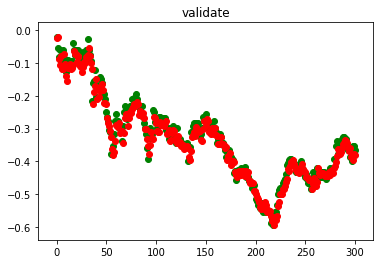

In [33]:
results=model.predict(x_val)
print( len(results) )
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

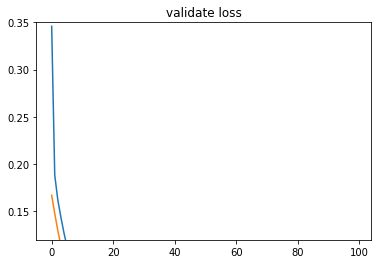

In [34]:
plt.ylim(0.12, 0.35)
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

In [35]:
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head(10)

,real,prediccion,diferencia
0,290.999992,290.344899,0.655092
1,286.000008,290.762729,-4.762721
2,281.999993,280.923383,1.076610
3,285.000004,278.446384,6.553620
4,280.000003,282.404688,-2.404686
5,280.000003,276.258175,3.741828
6,285.000004,276.682929,8.317075
7,281.500008,283.246561,-1.746553
8,276.999991,278.534764,-1.534772
9,275.000001,273.287149,1.712853


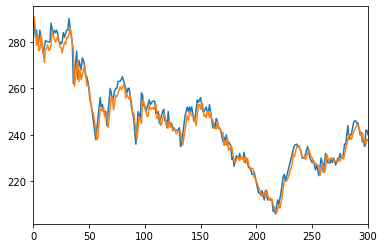

In [36]:
compara2['real'].plot()
compara2['prediccion'].plot()

In [37]:
ultimosDias = df['2019-8-15':'2019-9-6']
ultimosDias

,cierre,weekday,month,scaled
fecha,,,,
2019-09-01,252.0,6,9,-0.283784
2019-09-04,217.0,2,9,-0.520270
2019-09-05,210.0,3,9,-0.567567
2019-08-15,240.0,3,8,-0.364865
2019-08-16,243.0,4,8,-0.344594
2019-08-20,245.0,1,8,-0.331081
2019-08-21,246.0,2,8,-0.324324
2019-08-22,246.0,3,8,-0.324324
2019-08-23,245.0,4,8,-0.331081


In [38]:
scaledMerge=ultimosDias.drop('cierre',axis=1)
print(scaledMerge.values)

# frame as supervised learning
reframed = series_to_supervised(scaledMerge, PASOS, 1)
newReframed=reframed.drop(['var1(t)','var2(t)','var3(t)'],axis=1)
newReframed.head(7)

[[ 6.          9.         -0.28378367]
 [ 2.          9.         -0.52027023]
 [ 3.          9.         -0.56756747]
 [ 3.          8.         -0.36486483]
 [ 4.          8.         -0.34459448]
 [ 1.          8.         -0.33108103]
 [ 2.          8.         -0.32432425]
 [ 3.          8.         -0.32432425]
 [ 4.          8.         -0.33108103]
 [ 0.          8.         -0.33108103]
 [ 1.          8.         -0.35135126]
 [ 2.          8.         -0.36486483]
 [ 3.          8.         -0.35810804]
 [ 4.          8.         -0.38513505]]


,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var3(t-4),var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1)
fecha,,,,,,,,,,,,,,,,,,,,,
2019-08-22,6.0,9.0,-0.283784,2.0,9.0,-0.520270,3.0,9.0,-0.567567,3.0,...,-0.364865,4.0,8.0,-0.344594,1.0,8.0,-0.331081,2.0,8.0,-0.324324
2019-08-23,2.0,9.0,-0.520270,3.0,9.0,-0.567567,3.0,8.0,-0.364865,4.0,...,-0.344594,1.0,8.0,-0.331081,2.0,8.0,-0.324324,3.0,8.0,-0.324324
2019-08-26,3.0,9.0,-0.567567,3.0,8.0,-0.364865,4.0,8.0,-0.344594,1.0,...,-0.331081,2.0,8.0,-0.324324,3.0,8.0,-0.324324,4.0,8.0,-0.331081
2019-08-27,3.0,8.0,-0.364865,4.0,8.0,-0.344594,1.0,8.0,-0.331081,2.0,...,-0.324324,3.0,8.0,-0.324324,4.0,8.0,-0.331081,0.0,8.0,-0.331081
2019-08-28,4.0,8.0,-0.344594,1.0,8.0,-0.331081,2.0,8.0,-0.324324,3.0,...,-0.324324,4.0,8.0,-0.331081,0.0,8.0,-0.331081,1.0,8.0,-0.351351
2019-08-29,1.0,8.0,-0.331081,2.0,8.0,-0.324324,3.0,8.0,-0.324324,4.0,...,-0.331081,0.0,8.0,-0.331081,1.0,8.0,-0.351351,2.0,8.0,-0.364865
2019-08-30,2.0,8.0,-0.324324,3.0,8.0,-0.324324,4.0,8.0,-0.331081,0.0,...,-0.331081,1.0,8.0,-0.351351,2.0,8.0,-0.364865,3.0,8.0,-0.358108


In [39]:
values = newReframed.values
x_test = values[6:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
print(x_test)
ultDiaSemana = newReframed.index[len(newReframed.index)-1].weekday()


(1, 1, 21)
[[[ 2.          8.         -0.32432425  3.          8.
   -0.32432425  4.          8.         -0.33108103  0.
    8.         -0.33108103  1.          8.         -0.35135126
    2.          8.         -0.36486483  3.          8.
   -0.35810804]]]


In [40]:
def agregarNuevoValor(x_test,nuevoValor,ultDiaSemana):
    for i in range(x_test.shape[2]-3):
        x_test[0][0][i] = x_test[0][0][i+3]
    ultDiaSemana=ultDiaSemana+1
    if ultDiaSemana>6:
        ultDiaSemana=0
    x_test[0][0][x_test.shape[2]-3]=ultDiaSemana
    x_test[0][0][x_test.shape[2]-2]=12
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test,ultDiaSemana

In [41]:
results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print('pred',i,x_test)
    x_test,ultDiaSemana=agregarNuevoValor(x_test,parcial[0],ultDiaSemana)

pred 0 [[[ 2.          8.         -0.32432425  3.          8.
   -0.32432425  4.          8.         -0.33108103  0.
    8.         -0.33108103  1.          8.         -0.35135126
    2.          8.         -0.36486483  3.          8.
   -0.35810804]]]
pred 1 [[[ 3.          8.         -0.32432425  4.          8.
   -0.33108103  0.          8.         -0.33108103  1.
    8.         -0.35135126  2.          8.         -0.36486483
    3.          8.         -0.35810804  5.         12.
   -0.35944766]]]
pred 2 [[[ 4.          8.         -0.33108103  0.          8.
   -0.33108103  1.          8.         -0.35135126  2.
    8.         -0.36486483  3.          8.         -0.35810804
    5.         12.         -0.35944766  6.         12.
   -0.37059304]]]
pred 3 [[[ 0.          8.         -0.33108103  1.          8.
   -0.35135126  2.          8.         -0.36486483  3.
    8.         -0.35810804  5.         12.         -0.35944766
    6.         12.         -0.37059304  0.         12.
   -0.

In [42]:
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([-0.35944766], dtype=float32), array([-0.37059304], dtype=float32), array([-0.36484143], dtype=float32), array([-0.3726248], dtype=float32), array([-0.38703865], dtype=float32), array([-0.393445], dtype=float32), array([-0.3786008], dtype=float32)]


array([[240.80173315],
       [239.15221648],
       [240.00345471],
       [238.85151404],
       [236.71826672],
       [235.77012886],
       [237.96706732]])

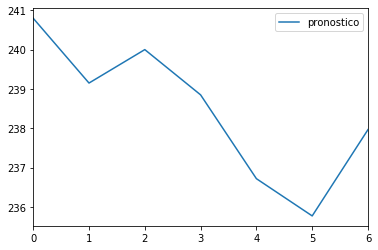

In [43]:
prediccion1SemanaDiciembre = pd.DataFrame(inverted)
prediccion1SemanaDiciembre.columns = ['pronostico']
prediccion1SemanaDiciembre.plot()
prediccion1SemanaDiciembre.to_csv('pronostico_multivariate.csv')


In [44]:
prediccion1SemanaDiciembre

,pronostico
0,240.801733
1,239.152216
2,240.003455
3,238.851514
4,236.718267
5,235.770129
6,237.967067
